# 0.0 Imports

In [3]:
import joblib
import os
import pandas                as pd
from sqlalchemy import       create_engine
import numpy                 as np
from dotenv import           load_dotenv
import matplotlib.pyplot     as plt
import seaborn               as sns

from sklearn.preprocessing   import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression

import scikitplot            as skpt

pd.set_option('display.max_columns', None)
pd.set_option("display.precision", 4)

# 1.0 Data Description

In [4]:
# pwd

In [5]:
# path = "C:\\repos\\portfolio_projetos\\pa004_health_insurance\\"

df_raw = pd.read_csv('../data/train.csv')
df_raw.columns = [x.lower() for x in df_raw.columns]

In [6]:
df1 = df_raw.copy()
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.1 Data Dimension

In [7]:
print('Dimensions => Rows: {} and Columns: {}'.format(df1.shape[0],df1.shape[1]))

Dimensions => Rows: 381109 and Columns: 12


## 1.2 Data Types

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NA

In [9]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Data Descriptive

In [10]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [11]:
# central tendency - mean / median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std / skew / kurtosis / min / max
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std', 'skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.0000,190555.0,110016.6919,9.4433e-16,-1.2000
1,age,20.0,85.0,65.0,38.8226,36.0,15.5116,6.7254e-01,-0.5657
2,driving_license,0.0,1.0,1.0,0.9979,1.0,0.0461,-2.1595e+01,464.3543
3,region_code,0.0,52.0,52.0,26.3888,28.0,13.2299,-1.1527e-01,-0.8679
4,previously_insured,0.0,1.0,1.0,0.4582,0.0,0.4983,1.6775e-01,-1.9719
5,annual_premium,2630.0,540165.0,537535.0,30564.3896,31669.0,17213.1325,1.7661e+00,34.0046
6,policy_sales_channel,1.0,163.0,162.0,112.0343,133.0,54.2039,-9.0001e-01,-0.9708
7,vintage,10.0,299.0,289.0,154.3474,154.0,83.6712,3.0295e-03,-1.2007
8,response,0.0,1.0,1.0,0.1226,0.0,0.3279,2.3019e+00,3.2988


In [12]:
# vintage => time as a client in the company

# 2.0 Feature Engineering

In [13]:
df2 = df1.copy()
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [14]:
df2['vehicle_age'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [15]:
# change vehicle_age to another interval
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else
                                             'between_1_2_years' if x == '1-2 Year' else
                                             'below_1_year')

# change vehicle_damage to number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)

# 3.0 Data Filtering

In [16]:
df3 = df2.copy()

# 4.0 EDA

In [17]:
df4 = df3.copy()

## 4.1 Univariate Analysis

In [18]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

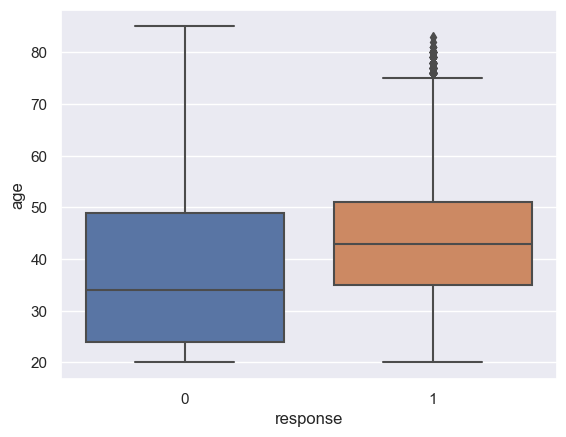

In [19]:
# 'age'
sns.set()
sns.boxplot(x = 'response', y = 'age', data = df4);

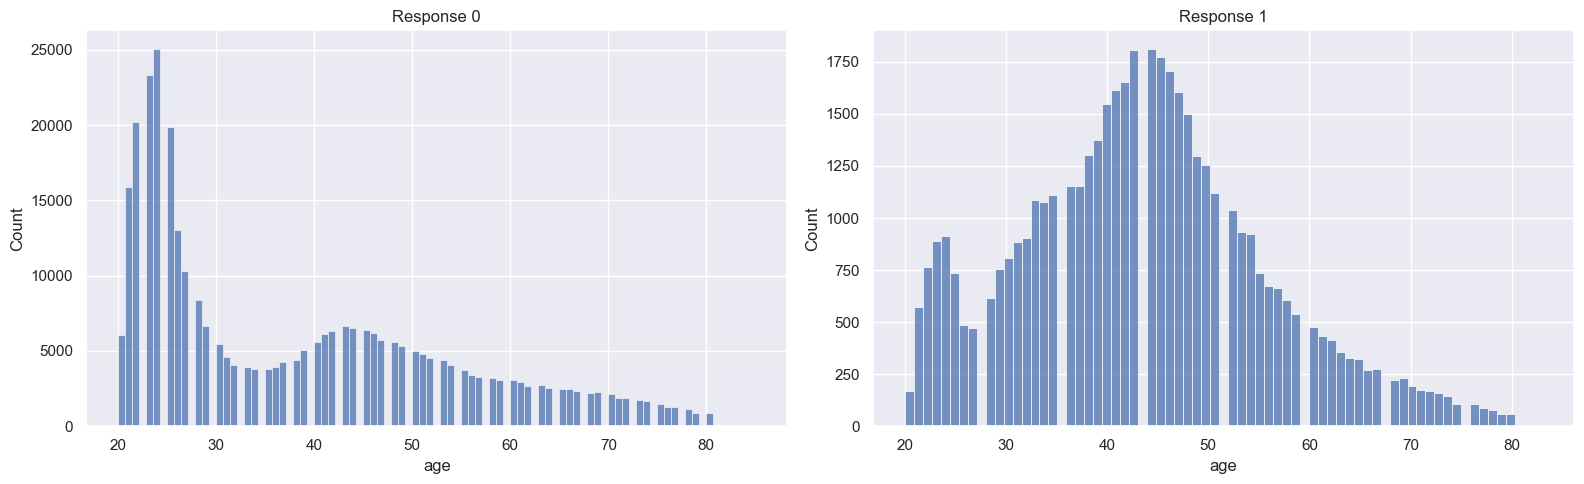

In [20]:
fig, axes = plt.subplots(1,2,figsize = (16,5))
aux00 = df4.loc[df4['response'] == 0, 'age']
aux01 = df4.loc[df4['response'] == 1, 'age']

axes[0].set_title('Response 0')
axes[1].set_title('Response 1')

sns.histplot(aux00, ax = axes[0]);
sns.histplot(aux01, ax = axes[1]);
plt.tight_layout()

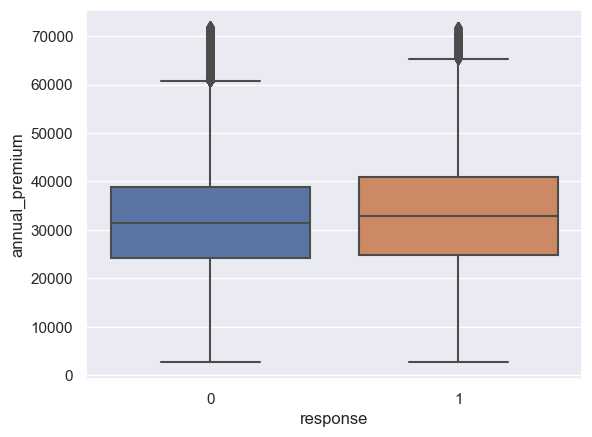

In [21]:
# 'annual_premium'
# aux = df4.loc[df4['annual_premium'] < 120000]

aux = df4.loc[df4['annual_premium'] < 72000]
sns.boxplot(x = 'response', y = 'annual_premium', data = aux);

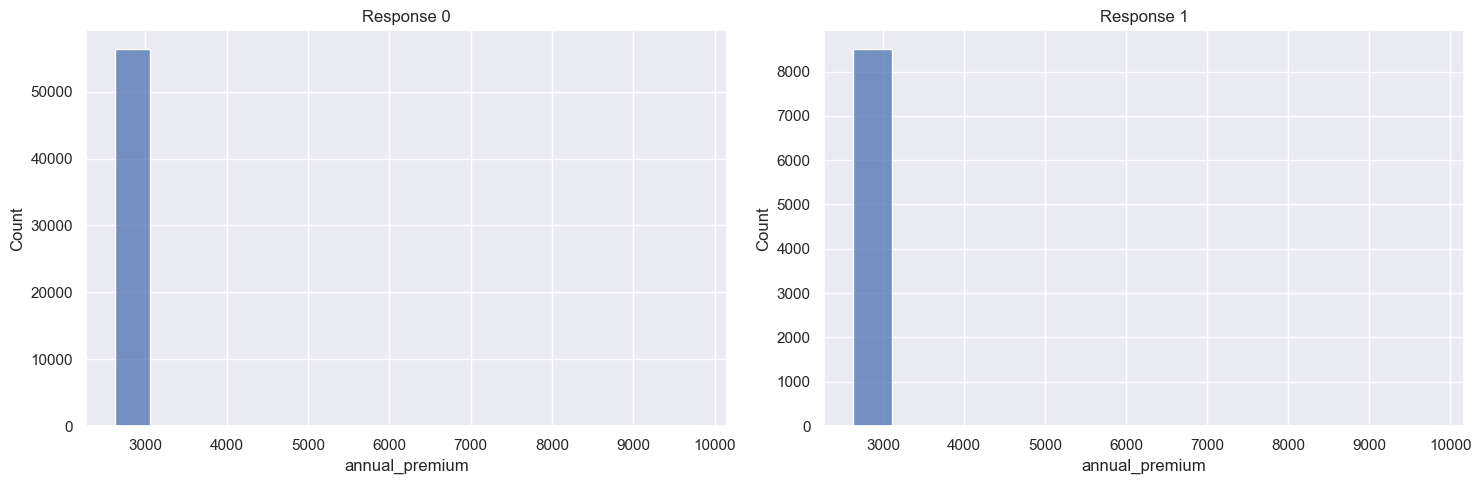

In [22]:
# 'annual_premium'
fig, axes = plt.subplots(1,2,figsize = (15,5))

aux = df4.loc[(df4['annual_premium'] < 10000)]

aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
aux01 = aux.loc[aux['response'] == 1, 'annual_premium']

axes[0].set_title('Response 0')
axes[1].set_title('Response 1')

sns.histplot(aux00, ax = axes[0]);
sns.histplot(aux01, ax = axes[1]);
plt.tight_layout()

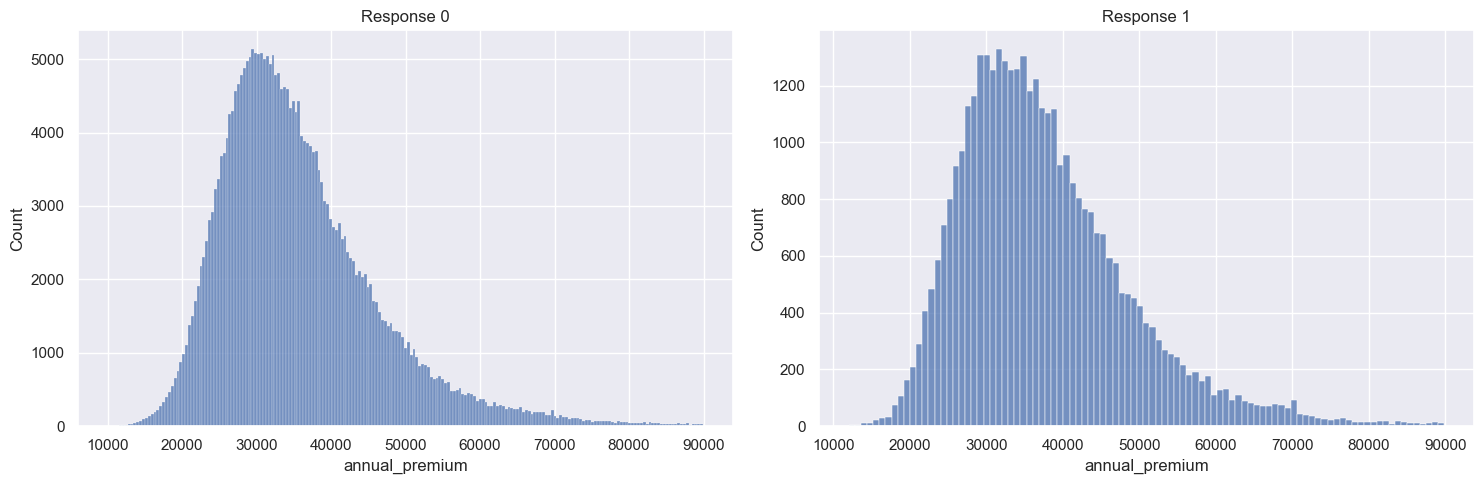

In [23]:
# 'annual_premium'
fig, axes = plt.subplots(1,2,figsize = (15,5))

aux = df4.loc[(df4['annual_premium'] >= 10000) & (df4['annual_premium'] < 90000)]

aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
aux01 = aux.loc[aux['response'] == 1, 'annual_premium']

axes[0].set_title('Response 0')
axes[1].set_title('Response 1')

sns.histplot(aux00, ax = axes[0]);
sns.histplot(aux01, ax = axes[1]);
plt.tight_layout()

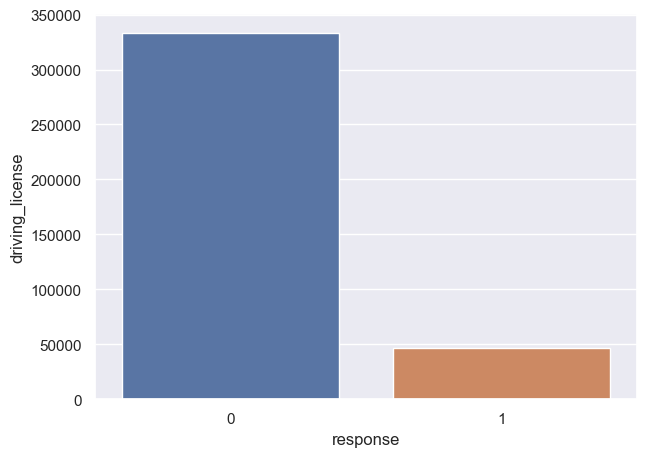

In [24]:
# 'driving_license'
fig, axes = plt.subplots(1,1,figsize = (7,5))
aux = df4[['driving_license','response']].groupby('response').sum().reset_index()
aux['perc_driving'] = aux['driving_license'] / aux['driving_license'].sum()
 
sns.barplot(x = 'response', y = 'driving_license', data = aux, ax = axes);

In [25]:
aux

,response,driving_license,perc_driving
0,0,333628,0.8773
1,1,46669,0.1227


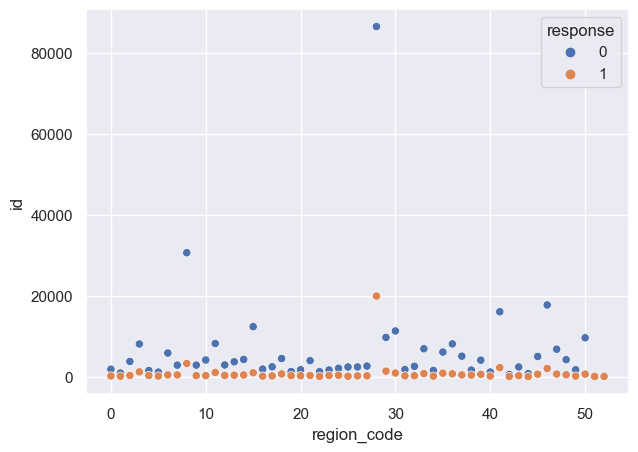

In [26]:
# 'region_code'
fig, axes = plt.subplots(1,1,figsize = (7,5))
aux = df4[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()

sns.scatterplot(x = 'region_code', y = 'id', hue = 'response', data = aux, ax = axes);

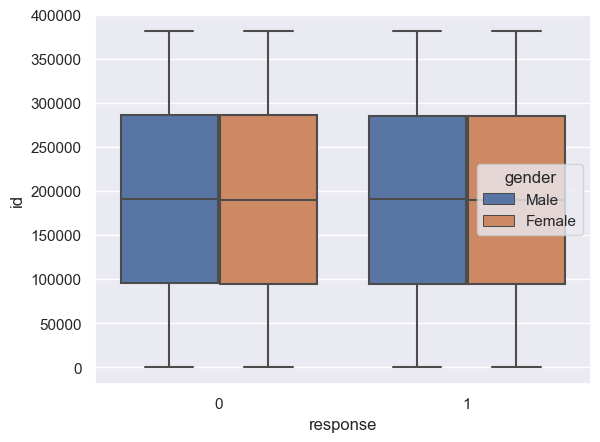

In [27]:
# 'gender'

sns.boxplot(x = 'response', y = 'id',hue = 'gender', data = df4);

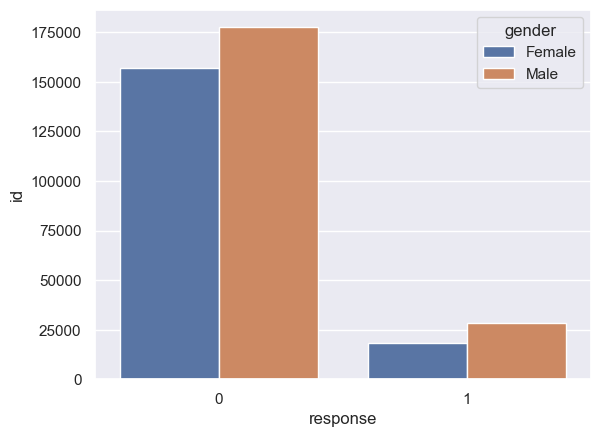

In [28]:
# gender
aux = df4[['gender','response','id']].groupby(['gender','response']).count().reset_index()

sns.barplot(data = aux, x='response', y='id', hue='gender');

In [29]:
# 'previously_insured'

pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum(), axis = 1)

response,0,1
previously_insured,,
0,0.7745,0.2255
1,0.9991,0.0009


In [30]:
# 'vehicle_age'

df4[['vehicle_age','response']].value_counts(normalize = True).reset_index().sort_values(by=['vehicle_age'])

,vehicle_age,response,0
1,below_1_year,0,0.4135
4,below_1_year,1,0.0189
0,between_1_2_years,0,0.4343
2,between_1_2_years,1,0.0913
3,over_2_years,0,0.0297
5,over_2_years,1,0.0123


In [31]:
# 'vehicle_damage'
df4[['vehicle_damage','response']].value_counts(normalize = True).reset_index().sort_values(by=['vehicle_damage','response'])

,vehicle_damage,response,0
0,0,0,0.4925
3,0,1,0.0026
1,1,0,0.3849
2,1,1,0.1200


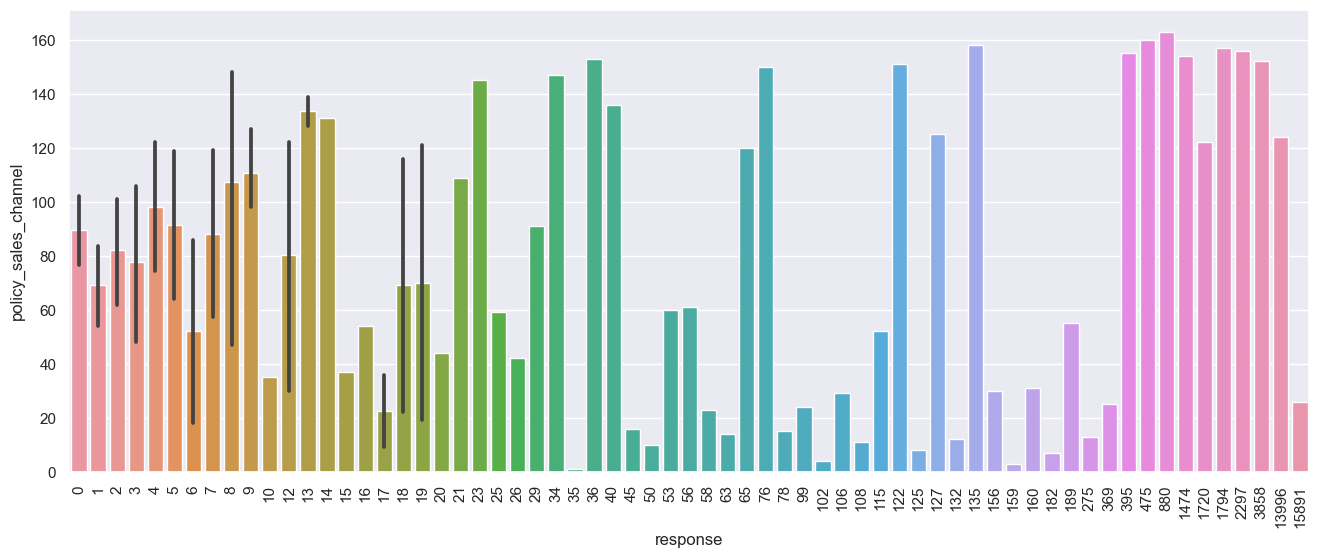

In [32]:
# 'policy_sales_channel'
fig, axes = plt.subplots(1,1,figsize = (16,6))
aux = df4[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()

sns.barplot(data = aux, x = 'response', y = 'policy_sales_channel', ax = axes);
plt.xticks(rotation = 90);

# try to create a percentage stacked barplot

<AxesSubplot:xlabel='response', ylabel='vintage'>

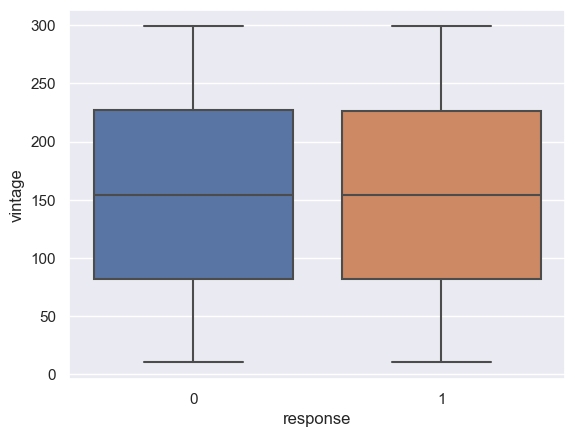

In [33]:
# 'vintage'

sns.boxplot(data = df4, x = 'response', y = 'vintage')

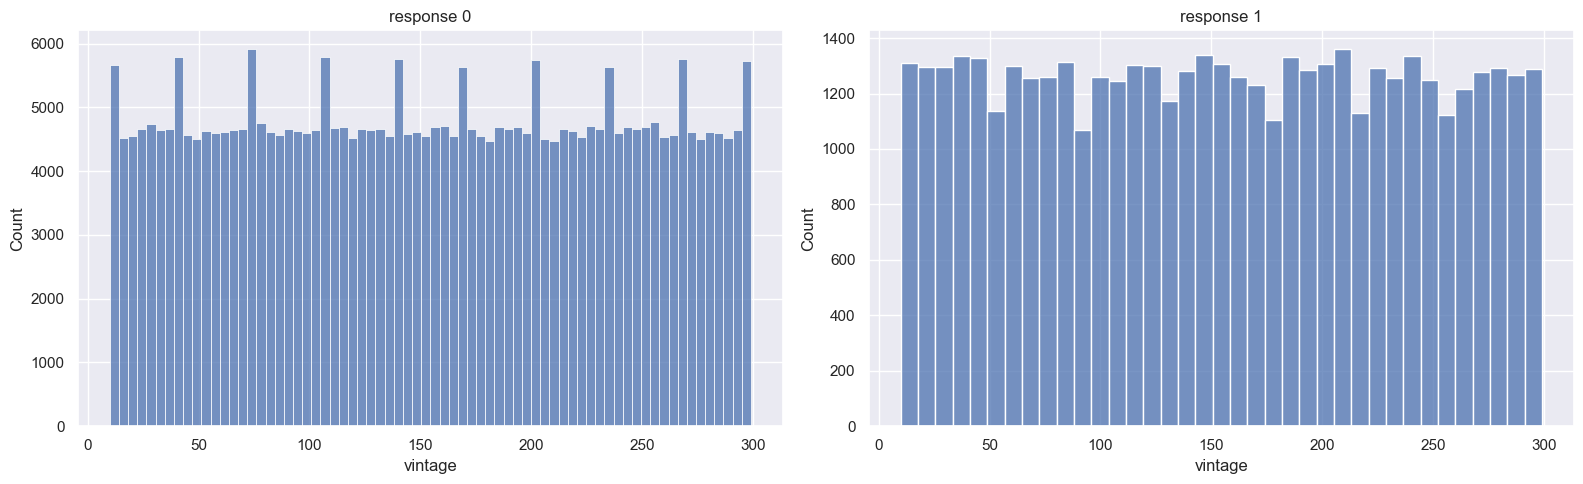

In [34]:
fig, axes = plt.subplots(1,2,figsize = (16,5))
aux00 = df4.loc[df4['response'] == 0, 'vintage']
aux01 = df4.loc[df4['response'] == 1, 'vintage']

sns.histplot(aux00, ax = axes[0]);
sns.histplot(aux01, ax = axes[1]);
axes[0].set_title('response 0');
axes[1].set_title('response 1');
plt.tight_layout();

# 5.0 Data Preparation

In [35]:
df5 = df4.copy()
df5.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [36]:
X = df4.drop( 'response', axis = 1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = train_test_split( X, y, test_size=0.2)

print(x_train.shape)
print(x_validation.shape)

df5 = pd.concat( [x_train, y_train], axis = 1)

(304887, 11)
(76222, 11)


## Standartization

In [37]:
ss = StandardScaler()

In [38]:
# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

## Rescaling

In [39]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

In [40]:
# age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )

# Save Scalings

In [41]:
joblib.dump(ss,'../models/standard_annual_premium.pkl')
joblib.dump(mms_age,'../models/min_max_age.pkl')
joblib.dump(mms_vintage,'../models/min_max_vintage.pkl')

['../models/min_max_vintage.pkl']

## Encoder

In [42]:
# gender => Target / OneHot encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5['gender'] = df5['gender'].map( target_encode_gender )

# region_code => Target / Frequency / Weighted target encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5['region_code'] = df5['region_code'].map( target_encode_region_code )

# vehicle_age => OneHot / Order encoding
df5 = pd.get_dummies(df5, prefix = 'vehicle_age', columns = ['vehicle_age'])

# policy_sales_channel => Target / Frequency encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len( df5 )
df5['policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )

In [43]:
joblib.dump(target_encode_gender,'../models/target_encode_gender.pkl')
joblib.dump(target_encode_region_code,'../models/target_encode_region_code.pkl')
joblib.dump(fe_policy_sales_channel,'../models/fe_policy_sales_channel.pkl')

['../models/fe_policy_sales_channel.pkl']

In [44]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years
166441,166442,0.1047,0.0615,1,0.0736,1,0,-0.2255,0.2093,0.3529,0,1,0,0
250598,250599,0.1047,0.4615,1,0.0736,1,0,1.0224,0.3536,0.2457,0,0,1,0
260350,260351,0.1386,0.6923,1,0.0649,0,1,-1.6269,0.0573,0.0242,0,0,1,0
287922,287923,0.1047,0.3846,1,0.0999,1,0,-1.6269,0.1942,0.7024,0,0,1,0
155265,155266,0.1047,0.0462,1,0.1035,1,0,1.5065,0.3536,0.2284,0,1,0,0


## Validation Preparation

In [45]:
# age
x_validation.loc[:, 'gender'] = mms_age.transform(x_validation[['age']].values )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# gender => Target / OneHot encoding
x_validation.loc[:, 'gender'] = x_validation.loc[:,'gender'].map( target_encode_gender )

# region_code => Target / Frequency / Weighted target encoding
x_validation.loc[:, 'region_code'] = x_validation.loc[:,'region_code'].map( target_encode_region_code )

# vehicle_age => OneHot / Order encoding
x_validation = pd.get_dummies(x_validation, prefix = 'vehicle_age', columns = ['vehicle_age'])

# policy_sales_channel => Target / Frequency encoding
x_validation.loc[:, 'policy_sales_channel'] = x_validation.loc[:,'policy_sales_channel'].map( fe_policy_sales_channel )

# fillna
x_validation = x_validation.fillna(0)

C:\Users\pedro\AppData\Local\Temp\ipykernel_17444\3243844252.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_validation.loc[:, 'gender'] = mms_age.transform(x_validation[['age']].values )


# 6.0 Feature Selection

## Feature Importance

In [46]:
# # model definition
# forest = ExtraTreesClassifier(n_estimators = 250, random_state = 42, n_jobs = 2)

# # data preparation
# x_train_n = df5.drop(['id','response'], axis = 1)
# y_train_n = df5['response'].copy()
# forest.fit(x_train_n, y_train_n)

In [47]:
# importances = forest.feature_importances_
# std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis = 0)
# indices = np.argsort(importances)[::-1]

# # print the feature ranking
# print('Feature ranking:')
# df = pd.DataFrame()

# for i,j in zip(x_train_n, forest.feature_importances_):
#     aux = pd.DataFrame( {'feature': i, 'importance': j}, index = [0])
#     df = pd.concat( [df, aux], axis = 0)
    
# print(df.sort_values('importance', ascending = False) )

# # plot the impurity-based feature importances of the forest
# plt.figure()
# plt.title('Feature importances')
# plt.bar(range(x_train_n.shape[1]), importances[indices], color = 'r', yerr=std[indices],align = 'center' )
# plt.xticks(range(x_train_n.shape[1]), indices)
# plt.xlim( [-1, x_train_n.shape[1]] )
# plt.show()

# 8.0 Machine Learning

In [48]:
cols_selected = ['vintage','annual_premium','age','region_code','vehicle_damage',
                 'policy_sales_channel','previously_insured']

x_train = df5[cols_selected]
x_val = x_validation[cols_selected]

## KNN

In [49]:
# model definition
knn_model = KNeighborsClassifier(n_neighbors = 19)

# model training
knn_model.fit(x_train, y_train)

# model predict => poder de generalização
yhat_knn = knn_model.predict_proba(x_val)

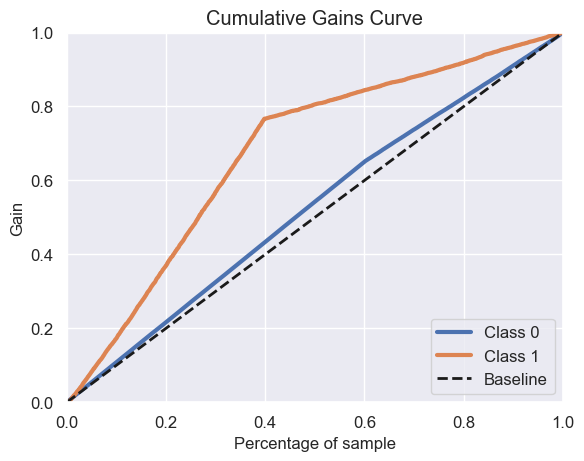

In [50]:
# cumulative gain
skpt.metrics.plot_cumulative_gain(y_validation, yhat_knn);

## Logistic Regression

In [51]:
# model definition
lr_model = LogisticRegression()

# model training
lr_model.fit(x_train, y_train)

# model predict => poder de generalização
yhat_lr = lr_model.predict_proba(x_val)

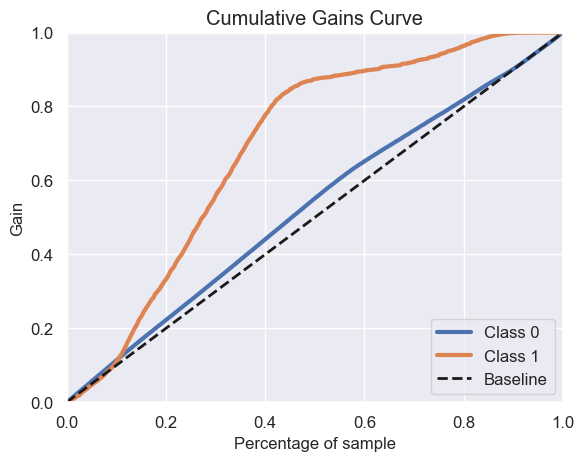

In [52]:
# cumulative gain
skpt.metrics.plot_cumulative_gain(y_validation, yhat_lr);

## ExtraTrees

In [53]:
# # model definition
# et_model = ExtraTreesClassifier(n_estimators = 400, n_jobs = 2, random_state = 42)

# # model training
# et_model.fit(x_train, y_train)

# # model predict => poder de generalização
# yhat_et = et_model.predict_proba(x_val)

In [54]:
# # cumulative gain
# skpt.metrics.plot_cumulative_gain(y_validation, yhat_et);

# Model Performance

In [55]:
def precision_at_k(data, k = 2000, target_col = 'response'):
    data = data.reset_index(drop = True)

    data['ranking'] = data.index + 1

    data['precision_at_k'] = data[target_col].cumsum() / data['ranking']

    return data.loc[k,'precision_at_k']

In [56]:
def recall_at_k(data, k = 2000, target_col = 'response'):
    data = data.reset_index(drop = True)

    data['ranking'] = data.index + 1

    data['recall_at_k'] = data[target_col].cumsum() / data[target_col].sum()

    return data.loc[k,'recall_at_k']

In [57]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_knn[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values(by=['score'], ascending = False)

In [58]:
# compute precision "at k"
precision_at_50 = precision_at_k(data = df8, k = 50, target_col = 'response')
precision_at_50

0.1568627450980392

In [59]:
# compute recall "at k"
recall_at_50 = recall_at_k(data = df8, k = 50, target_col = 'response')
recall_at_50

0.0008687153871212944

# Deploy to Production

In [60]:
joblib.dump(lr_model,'../models/logreg_classifier.pkl')

['../models/logreg_classifier.pkl']

## Health Insurance Class

In [61]:
import pandas as pd
import numpy as np
import joblib

class HealthInsurance:
    def __init__(self) -> None:
        self.home_path = 'C:\repos\portfolio_projetos\pa004_health_insurance'
        self.standard_annual_premium = joblib.load(self.home_path + '\\models\\standard_annual_premium.pkl')
        self.min_max_age = joblib.load(self.home_path + '\\models\\min_max_age.pkl')
        self.min_max_vintage = joblib.load(self.home_path + '\\models\\min_max_vintage.pkl')
        self.fe_policy_sales_channel = joblib.load(self.home_path + '\\models\\fe_policy_sales_channel.pkl')
        self.target_encode_gender = joblib.load(self.home_path + '\\models\\target_encode_gender.pkl')
        self.target_encode_region_code = joblib.load(self.home_path + '\\models\\target_encode_region_code.pkl')


    def data_cleaning(self, df1):
        df1.columns = [x.lower() for x in df1.columns]
        return df1
        
    
    def feature_engineering (self, df2):
        # change vehicle_age to another interval
        df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else
                                             'between_1_2_years' if x == '1-2 Year' else
                                             'below_1_year')
        # change vehicle_damage to number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)
        return df2


    def data_preparation (self, df5):
        # annual premium
        df5['annual_premium'] = self.standard_annual_premium.fit_transform( df5[['annual_premium']].values )

        # age
        df5['age'] = self.min_max_age.fit_transform( df5[['age']].values )

        # vintage
        df5['vintage'] = self.min_max_vintage.fit_transform( df5[['vintage']].values )

        # gender => Target / OneHot encoding
        df5.loc[:, 'gender'] = df5.loc[:,'gender'].map( self.target_encode_gender )

        # region_code => Target / Frequency / Weighted target encoding
        df5.loc[:, 'region_code'] = df5.loc[:,'region_code'].map( self.target_encode_region_code )

        # vehicle_age => OneHot / Order encoding
        df5 = pd.get_dummies(df5, prefix = 'vehicle_age', columns = ['vehicle_age'])

        # policy_sales_channel => Target / Frequency encoding
        df5.loc[:, 'policy_sales_channel'] = df5.loc[:,'policy_sales_channel'].map( self.fe_policy_sales_channel )

        # fillna
        df5 = df5.fillna(0)

        # relevant columns
        cols_selected = ['vintage','annual_premium','age','region_code','vehicle_damage',
                 'policy_sales_channel','previously_insured']

        return df5[cols_selected]


    def get_prediction( self, model, dataset, x_test ):
        #model prediction
        predictions = model.predict_proba( x_test )

        #join prediction into original data and sort
        dataset['score'] = predictions[:, 1].tolist()
        dataset = dataset.sort_values('score', ascending=False)

        return dataset.to_json( orient= 'records', date_format = 'iso' )

## API Handler

In [ ]:
import joblib
import pandas as pd
from flask import Flask, request, Response

# load model
path = r'C:\repos\portfolio_projetos\pa004_health_insurance'
model = '\\models\logreg_classifier.pkl'

# initialize API
app = Flask(__name__)

@app.route('/healthinsurance/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])

        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # initialize class
        pipeline = HealthInsurance()

        df1 = pipeline.data_cleaning(test_raw)

        df2 = pipeline.feature_engineering(df1)

        df3 = pipeline.data_preparation(df2)

        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response
    
    else:
        return Response('{}', status = 200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run('0.0.0.0',debug=True)
